In [2]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run 2d_lipm_env.ipynb #imports LIPM Env

In [3]:
class Buffer:
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.buffer = np.zeros((1, 7 + 2 + 1 + 7)) ## should be made variables
        
    def size(self):
        
        return len(self.buffer)
    
    def store(self, state, action, reward, next_state, done):
        ## stores new data in the buffer
        new_data = 9999*np.ones((1, 7 + 2 + 1 + 7))
        new_data[0, 0:7] = state
        new_data[0, 7:10] = [action[0], action[1], reward]
        if not done:
            new_data[0, 10:] = next_state 
        else:
            new_data[0, 10:] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        self.buffer = np.concatenate((self.buffer, np.around(new_data, 2)), axis = 0)
        
        #removes the first element if it is zero.
        if np.all(self.buffer[0] == 0):
            self.buffer = self.buffer[1:]
            
        # removes first element if the desired buffer size is obtained
        elif self.size() > self.buffer_size:
            self.buffer = self.buffer[1:]
            
    def sample(self, batch_size):
        # returns a random mini batch of desired batch size
        return np.asarray(random.sample(list(self.buffer), batch_size))

In [4]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 512)
        self.l4 = nn.Linear(512, 512)
        self.l5 = nn.Linear(512, 512)
        self.l6 = nn.Linear(512, 512)
        self.l7 = nn.Linear(512, 512)
        self.l8 = nn.Linear(512, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = F.relu(self.l5(x))
        x = F.relu(self.l6(x))
        x = F.relu(self.l7(x))
        x = self.l8(x)
        return x

In [5]:
class TwoDQStepper:
    def __init__(self, no_actions = [9, 7], lr = 1e-4, gamma = 0.9, use_tarnet = False, trained_model = None):
        '''
        This is a 2d dq stepper.
        State = [x-ux, y - uy, xd, yd, n, action_x, action_y]
        '''
        self.device = torch.device("cpu")
        self.dq_stepper = NN(9, 1).to(self.device) #state+ action -> q_value
        if trained_model:
            self.dq_stepper.load_state_dict(torch.load(trained_model))
            self.dq_stepper.eval()
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(9, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        assert len(no_actions) == 2
        self.no_actions = no_actions
        
        # This is the template of x_in that goes into the dq stepper
        self.x_in = np.zeros((self.no_actions[0]*self.no_actions[1], 9))
        self.x_in[:,7] = np.tile(np.arange(self.no_actions[0]), self.no_actions[1])
        self.x_in[:,8] = np.repeat(np.arange(self.no_actions[1]), self.no_actions[0])
                  
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
            action_index = np.argmin(q_values)
            action_x = int(action_index%self.no_actions[0])
            action_y = int(action_index//self.no_actions[0])
        return [action_x, action_y], q_values[action_index]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            action_x = np.random.randint(self.no_actions[0])
            action_y = np.random.randint(self.no_actions[1])
            return [action_x, action_y]
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:9].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,9].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,10:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,10:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,10:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, e, figsize=(15,25), window = 500, title='history'):
        clear_output(wait=True)
        clear_output(wait=True)
        fig, ax = plt.subplots(3, 1, figsize=figsize)
        ax[0].plot(history['epi_cost'], label='epi_cost', color = 'orange')
        ax[0].grid(True)
        ax[0].legend() # the plot evolves to the right
        if e > window:
            ax[1].plot(np.arange(e-window+1, e), history['epi_cost'][e-window:], label='epi_cost zoom')
            ax[1].grid(True)
            ax[1].legend() # the plot evolves to the right
        ax[2].plot(history['loss'], label='loss', color = 'black')
        ax[2].grid(True)
        ax[2].legend() # the plot evolves to the right
        ax[2].set_ylim(0, 100)
        plt.xlabel('episode')
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        self.x_in[:,[0, 1, 2, 3, 4, 5, 6]] = x
        torch_x_in = torch.FloatTensor(self.x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

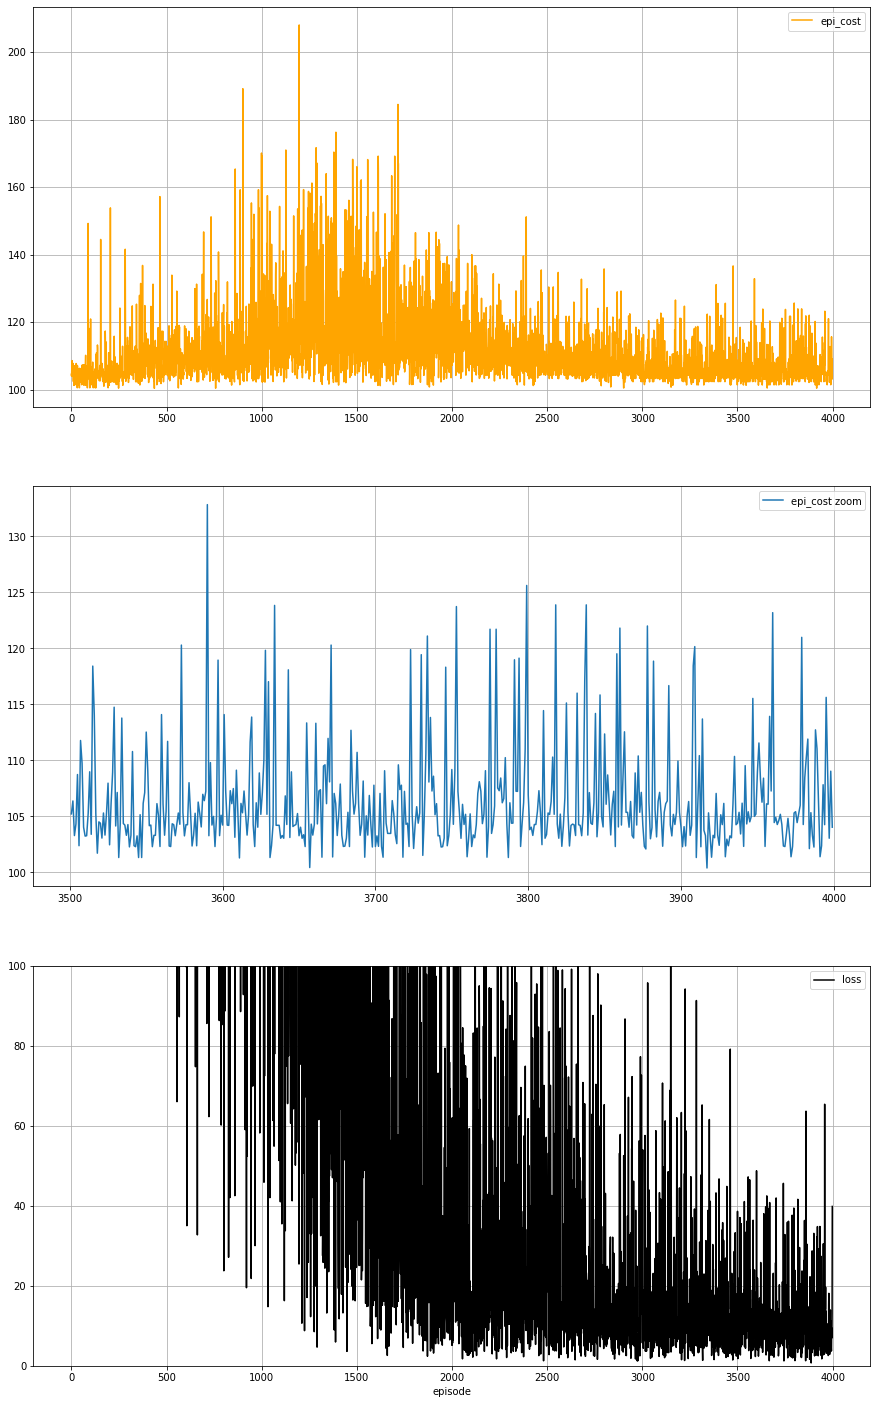

KeyboardInterrupt: 

In [6]:
e = 1
no_epi = 10000
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = TwoDLipmEnv(0.2, 0.13, 0.22, [1, 3, 0], no_actions= [11, 9])
no_actions = [len(env.action_space_x), len(env.action_space_y)]
print(no_actions)
buffer_size = 10000
buffer = Buffer(buffer_size)

name = "dqs_1"
dqs = TwoDQStepper(lr=1e-4, gamma=0.98, use_tarnet= True, no_actions= no_actions)
batch_size = 16
epsillon = 0.2

history = {'loss':[], 'epi_cost':[]}
while e < no_epi:
    v_init = [0.25*np.random.randint(-4, 5), 0.25*np.random.randint(-2, 3)]
    v_des = [0.0, 0.0]
    state = env.reset_env([0.0, 0.0, v_init[0], v_init[1]], v_des, no_steps*step_time)
    if e % 500 == 0 and e > 10:
        torch.save(dqs.dq_stepper.state_dict(), "../../models/" + name)
        dqs.live_plot(history, e)
        #reducing epsillon
        if e%1000 == 0 and e > 5000:
            epsillon = epsillon/2
            
    if buffer.size() == buffer_size:
        history['epi_cost'].append(epi_cost)
        history['loss'].append(loss)
        e += 1
    
    epi_cost = 0
    
    for n in range(no_steps):
        action = dqs.predict_eps_greedy(state, epsillon)
        next_state, cost, done = env.step_env(action, step_time)
        buffer.selse:
                action = [7, 5]
            tore(state, action, cost, next_state, done)
        state = next_state
        
        if buffer.size() == buffer_size:
            ## optimizing DQN
            loss = dqs.optimize(buffer.sample(batch_size)) 
            epi_cost += cost
        if done:
            break
        